# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a coffee shop. Specifically, this report will be targeted to stakeholders interested in opening an <b>coffee shop</b> near to <b>Downtown Miami</b>, in Florida.

Since there are lots of cafes in Downtown Miami, we will try to detect <b>the most suitable location, in or around the surrounding neighborhoods</b>, where the business can thrive. We are also particularly interested in <b>areas with popular venues or businesses to attract potential customers</b>. 

We will use our data science skills to evaluate a few of the most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* the distance of neighborhood from the Downtown area 
* number of coffee shops in the neighborhood 
* number of possible supporting business areas and popular venues in the neighborhood, if any. 
      
This information will be key in developing our analytical model and will be sufficient to obtain our solution. To gather this information the following data sources will be used:
* A Wikipedia entry with a list of neighborhoods in Miami. The web page consists of the neighborhoods and also their geographical coordinate data. This data will be   scrapped, formatted and cleaned to be utilized in our analysis.
  https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami
      
* To investigate the competitive environment in each neighborhood, such as existing coffee shops and other businesses or general places of interest. This data will   be retrieved using the Foursquare API. Foursquare claims to be the most trusted, independent location data and technology platform for businesses.

In [ ]:
#Import Libraries
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from urllib.request import urlopen

import json
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium

In [ ]:
!pip install shapely
import shapely.geometry
!pip install pyproj
import pyproj
import math

In [71]:
address = 'Miami'

geolocator = Nominatim(user_agent="mi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Miami are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Miami are 25.7742658, -80.1936589.


<br/>
Let's start by scrapping and cleaning the neighborhood and location data from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami'
df_raw = pd.read_html(url, attrs={'class': 'wikitable'})
df = df_raw[0]

#Drop unnecessary columns
df.drop(columns=['Demonym','Sub-neighborhoods'], inplace=True)

#Remove rows with no coordinate data
df.dropna(subset=['Coordinates'], inplace=True)

df = df.rename(columns={'Coordinates': 'Latitude'})
df['Longitude'] = df['Latitude']

for index, row in df.iterrows():
    row['Latitude'] = str(row['Latitude']).split('-')[0]
    row['Longitude'] = "-" + str(row['Longitude']).split('-')[1]

df["Latitude"] = pd.to_numeric(df["Latitude"])
df["Longitude"] = pd.to_numeric(df["Longitude"])

#print(str(max_lat) + "," + str(max_lon))

<br/>
The information gathered, contains all the neighborhoods in Miami, including some population statistics and importantly Latitude and Longitude information.
<br/>
Some unnecessary columns were removed, and also rows with no location coordinates were removed.
<br/>
The data looks as follows:

In [5]:
df.loc[:,:]

,Neighborhood,Population2010,Population/Km²,Latitude,Longitude
0,Allapattah,54289,4401,25.815,-80.224
1,Arts & Entertainment District,11033,7948,25.799,-80.190
2,Brickell,31759,14541,25.758,-80.193
3,Buena Vista,9058,3540,25.813,-80.192
4,Coconut Grove,20076,3091,25.712,-80.257
5,Coral Way,35062,4496,25.750,-80.283
6,Design District,3573,3623,25.813,-80.193
7,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
8,Edgewater,15005,6675,25.802,-80.190
9,Flagami,50834,5665,25.762,-80.316


<br/>
<p>
The next steps will process the dataframe further. Because we only want the neighborhoods closest to Downtown Miami, we will take the coordinates of Downtown, utilize this as our central point, and refine our list of neighborhoods to only those within a 2.5km distance.
</p>
<p>
    To accomplish this, a function to calculate <b>haversine formula</b> is defined.
</p>
<p>
The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.
</p>

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

downtown = df.loc[df['Neighborhood'] == "Downtown"]
downtown

downtown_lat = downtown["Latitude"].tolist()[0]
downtown_lon = downtown["Longitude"].tolist()[0]
max_lat = downtown["Latitude"].tolist()[0] + 0.04
max_lon = downtown["Longitude"].tolist()[0] + 0.04

radius = 2.50 # in kilometer
df_selected = df.copy(deep=True)
for index, row in df.iterrows():
    a = haversine(downtown_lat, downtown_lon, row['Latitude'], row['Longitude'])
    if a > radius:
        #Remove neighborhood from list if not within 2.5km of Downtown
        df_selected.drop(index, inplace=True)
        
df_selected.reset_index(drop=True, inplace=True)


The neighborhoods within 2.5km of Downtown Miami are as follows:

In [7]:
display(df_selected)

,Neighborhood,Population2010,Population/Km²,Latitude,Longitude
0,Brickell,31759,14541,25.758,-80.193
1,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193
2,Little Havana,76163,8423,25.773,-80.215
3,Lummus Park,3027,3680,25.777,-80.201
4,Overtown,6736,3405,25.787,-80.201
5,Park West,4655,3635,25.785,-80.193
6,The Roads,7327,4899,25.756,-80.207


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [8]:
mmap = folium.Map(location=[latitude, longitude], zoom_start=14)
folium.Marker([downtown_lat, downtown_lon], popup='Downtown, Miami').add_to(mmap)
folium.Circle([downtown_lat, downtown_lon], radius=2500, color='blue', fill=True, fill_color='blue', fill_opacity=.5).add_to(mmap)

for lat, lon, neigh in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    folium.Marker([float(lat), float(lon)], popup=neigh).add_to(mmap)
mmap

As we can see, the 7 identified neighborhoods are represented by the 7 markers on the map within the blue circle which represents the 2.5km distance from Downtown.

Looking good. Let's now place all this into a Pandas dataframe.

<b>Foursquare</b><br/>
Now that we have our location candidates, let's use Foursquare API to get info on coffee shops and places of interest in each neighborhood.

In [ ]:
import requests # library to handle requests

CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 50

In [ ]:
del venues_df

In [12]:
#Get places of interest
search_query = ''
for index, row in df_selected.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, row['Latitude'], row['Longitude'], VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    
    df_selected.loc[index, 'Venue_Count'] = len(venues)
    temp_df = json_normalize(venues)
    temp_df['location.neighborhood'] = row['Neighborhood']
    try: 
        venues_df = venues_df.append(temp_df)
    except NameError: 
        venues_df = temp_df


In [13]:
#Drop unnecessary columns
venues_df.drop(columns=['referralId','venuePage.id','location.postalCode','location.state','location.distance','location.formattedAddress','location.labeledLatLngs','location.cc','location.city','location.country','location.crossStreet','categories','delivery.id','delivery.provider.icon.name','delivery.provider.icon.prefix','delivery.provider.icon.sizes','delivery.provider.name','delivery.url','hasPerk'], inplace=True)
venues_df

,id,location.address,location.lat,location.lng,location.neighborhood,name
0,528e9e3611d204ff966db242,1451 Brickell Ave,25.758121,-80.192405,Brickell,Echo Brickell
1,4c2765f7a852c9287122e86c,1501 Brickell Ave,25.757828,-80.192876,Brickell,St. Jude's Catholic Church
2,4c6989c5897b1b8dc779af17,1450 Brickell Ave,25.758584,-80.192926,Brickell,1450 Brickell Ave
3,5888a923d9705c4cabe4abb6,NaN,25.758211,-80.193154,Brickell,Google Miami
4,4e4430767d8bee28239a299a,1450 Brickell Ave,25.758583,-80.192805,Brickell,City National Bank
5,4f5e0070e4b0838069ad9c14,NaN,25.761573,-80.198373,Brickell,Haitian Consulate
6,4b069b0ff964a520a6ed22e3,1435 Brickell Ave,25.759078,-80.191875,Brickell,Four Seasons Hotel Miami
7,4c14d4b377cea593da28d160,1441 Brickell Ave,25.765550,-80.193810,Brickell,Equinox Brickell Heights
8,51ec2413498eeefcf822875a,NaN,25.757833,-80.193192,Brickell,Trolley stop SE 15th Rd
9,50700f74e4b010c1aedf7217,1451 S Miami Ave,25.759456,-80.193812,Brickell,One Broadway


In [63]:
del shops_df

In [14]:
#Get coffee shops
search_query = 'Coffee'

for index, row in df_selected.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, row['Latitude'], row['Longitude'], VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()

    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    df_selected.loc[index, 'Coffee_Shop_Count'] = len(venues)
        
    temp_df = json_normalize(venues)
    temp_df['location.city'] = row['Neighborhood']
    temp_df.rename({'location.city':'location.neighborhood'}, axis=1, inplace=True)
    
    if(len(temp_df) > 0):
        try: 
            #shops_df = shops_df.append(json_normalize(venues),sort=False, ignore_index=True) 
            shops_df = shops_df.append(temp_df,sort=False, ignore_index=True) 
        except NameError: 
            shops_df = temp_df

            

In [15]:
#Drop unnecessary columns ,'location.neighborhood'
shops_df.drop(columns=['referralId','venuePage.id','location.postalCode','location.state','location.distance','location.formattedAddress','location.labeledLatLngs','location.cc','location.country','location.crossStreet','categories','delivery.id','delivery.provider.icon.name','delivery.provider.icon.prefix','delivery.provider.icon.sizes','delivery.provider.name','delivery.url','hasPerk'], inplace=True)
shops_df

,id,location.address,location.neighborhood,location.lat,location.lng,name
0,4f3277ef19836c91c7dac4c7,1541 Brickell Ave,Brickell,25.757370,-80.193590,Mercon Coffee
1,5c5331c6237dee002c137375,1200 Brickell Bay Dr,Brickell,25.761971,-80.190529,Finca’s Coffee
2,570a5464498e19cf050fad39,299 Se 3rd St,Downtown,25.772535,-80.190724,Allegro Coffee Company
3,4dee656345dd3aa41d7c07a9,117 SE 2nd Ave,Downtown,25.772994,-80.190179,Eternity Coffee Roasters
4,539a5461498e606f9b31c2bb,2 W Flagler St,Downtown,25.773989,-80.193687,Bistro Coffee
5,4f32286b19836c91c7bbdf44,145 E Flagler St,Downtown,25.774293,-80.190945,Ever Coffee
6,4c11398e3ce120a1945d091c,444 Brickell Ave,Downtown,25.769225,-80.190680,Coffee To Go
7,4f327aa319836c91c7dbcc5b,1 SE 3rd Ave,Downtown,25.774260,-80.189000,Q Coffee Club
8,4f3240e519836c91c7c55b36,16 NE 3rd Ave,Downtown,25.774416,-80.188576,Panini Coffee Bar
9,5bf0eeab25fb7b002cd8a7e2,200 NW 1st Ave,Downtown,25.777711,-80.195711,Parliament Coffee


<br/>
The following is a summary of the information gathered per neighborhood.

In [16]:
df_selected

,Neighborhood,Population2010,Population/Km²,Latitude,Longitude,Venue_Count,Coffee_Shop_Count
0,Brickell,31759,14541,25.758,-80.193,50.0,2.0
1,Downtown,"71,000 (13,635 CBD only)",10613,25.774,-80.193,50.0,12.0
2,Little Havana,76163,8423,25.773,-80.215,50.0,1.0
3,Lummus Park,3027,3680,25.777,-80.201,50.0,0.0
4,Overtown,6736,3405,25.787,-80.201,50.0,0.0
5,Park West,4655,3635,25.785,-80.193,50.0,1.0
6,The Roads,7327,4899,25.756,-80.207,50.0,0.0


<br/>
Check to see if any of the data accumulated contains duplicate information.

In [17]:
dup_shops = shops_df[shops_df.duplicated()]
dup_venues = venues_df[venues_df.duplicated()]
print("Duplicate coffee shops found: " + str(len(dup_shops)))
print("Duplicate places of interests found: " + str(len(dup_venues)))

Duplicate coffee shops found: 0
Duplicate places of interests found: 350


<br/>
No duplicates were found therefore no further cleaning is required.
<br/>
This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal location.
<br/>
<hr/>

## Methodology <a name="methodology"></a>

<p>In this project we will direct our efforts on detecting areas around Downtown Miami that have a low saturation of coffee shops, and a high number of businesses or areas of interest in which the business can thrive. We will limit our analysis to area of 2.5km around the city’s center.
</p>
<p>
In first step we established our understanding of the business problem. Secondly, we collected and cleaned the required data, inclusive of location information for neighborhoods, coffee shops, and other general venues of interest that would provide customers. During the data cleaning process we also narrowed the list of available neighborhoods to only those within 2.5km of Downtown Miami. This was done using the haversine formula, which is used to determine the great-circle distance between two points on a sphere given their longitude and latitude values.
</p>
<p>
The third step, will be our analysis of the data acquired. Some basic exploratory statistics will be calculated to get acquainted with the data, such as number of coffee shops found, the average number of coffee shops per neighborhood etc. Then, all the information collected will be sketched onto a map to provide a visual perspective of the data. We would be able to see all of the selected neighborhoods, all venues of interests, and all coffee shops. 
</p>
<p>
As we continue our analysis process, we would then further refine the information by categorizing the data of the neighborhoods by the average number of coffee shops. The categories would cover those above average, below average, or those with no coffee shops at all. We would iterate this process to narrow down the best neighborhood for the business.
</p>
<p>
In the final step of the analysis we would seek to pinpoint the most promising location in the preferred neighborhood for the coffee shop by identifying the area with the most dense venues. To accomplish this, we would use the k-means clustering, machine learning algorithm.
</p>

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data.

In [18]:
print('Total number of places of interests:', len(venues_df))
print('Total number of coffee shops:', len(shops_df))
print('Percentage of coffee shops to general places of interests: {:.2f}%'.format(len(shops_df) / len(venues_df) * 100))
avg_shop_per_neigh = round(df_selected["Coffee_Shop_Count"].mean(),3)
print('Average number of coffee shops per neighborhood:', avg_shop_per_neigh)


Total number of places of interests: 700
Total number of coffee shops: 16
Percentage of coffee shops to general places of interests: 2.29%
Average number of coffee shops per neighborhood: 2.286


<br/>
Next, the information collected is sketched onto the map for visual representation.
<br/>Coffee shops are marked in red and other places of interest are marked in blue

In [72]:
mmap = folium.Map(location=[latitude, longitude], zoom_start=14)

#Highlight the target area with a blue circle
folium.Marker([downtown_lat, downtown_lon], popup='Downtown, Miami').add_to(mmap)
folium.Circle([downtown_lat, downtown_lon], radius=2500, color='blue', fill=True, fill_color='blue', fill_opacity=.1).add_to(mmap)

#Place markers to depict the selected neighborhoods
for lat, lon, neigh in zip(df_selected['Latitude'],df_selected['Longitude'],df_selected['Neighborhood']):
    folium.Marker([float(lat), float(lon)], popup=neigh).add_to(mmap)
    

#Add venues / businesses / places of interest to the map
#The color of these items have been set to blue
for lat, lng, name, address in zip(venues_df['location.lat'], venues_df['location.lng'], venues_df['name'], venues_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mmap)  
    

#Add coffee shop locations to the map
#The color used to mark coffee shops have been set to red
for lat, lng, name, address in zip(shops_df['location.lat'], shops_df['location.lng'], shops_df['name'], shops_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(mmap)  
mmap

With the information placed onto the map, we can now easily see the clusters of venues around the target neighborhoods.

We can also tell that some neighborhoods do not have any coffee shops in close proximity. Lets refine the map some more to more clearly identify the clusters. 

First lets add a category column to the dataset which identifies the clusters in comparison with the average coffee shops per neighborhood.
<ul>
    <li>Neighborhoods above the ratio will be coded in red.</li>
    <li>Neighborhoods below the ratio will be coded in yellow.</li>
    <li>Neighborhoods with no coffee shops will be coded in gray.</li>
</ul>

In [24]:
for index, row in df_selected.iterrows():
    if(row['Coffee_Shop_Count'] > avg_shop_per_neigh):
        df_selected.loc[index, 'Category'] = 'red'
    else:
        if(row['Coffee_Shop_Count'] == 0):
            df_selected.loc[index, 'Category'] = 'gray'
        else:
            df_selected.loc[index, 'Category'] = 'yellow'

In [25]:
mmap = folium.Map(location=[latitude, longitude], zoom_start=14)

#Place markers to depict the selected neighborhoods
for lat, lon, neigh, category in zip(df_selected['Latitude'],df_selected['Longitude'],df_selected['Neighborhood'],df_selected['Category']):
    folium.Marker([float(lat), float(lon)], popup=neigh).add_to(mmap)
    folium.Circle([float(lat), float(lon)], radius=500, color=category, fill=True, fill_color=category, fill_opacity=.3).add_to(mmap)

#Add venues / businesses / places of interest to the map
#The color of these items have been set to blue
for lat, lng, name, address in zip(venues_df['location.lat'], venues_df['location.lng'], venues_df['name'], venues_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mmap)  
    

#Add coffee shop locations to the map
#The color used to mark coffee shops have been set to red
for lat, lng, name, address in zip(shops_df['location.lat'], shops_df['location.lng'], shops_df['name'], shops_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(mmap)  
mmap

We can clearly visualize the groups of clusters now with the color coding.
<br/><br/>
Lets further refine the map, and focus on the gray categories which have no coffee shops in a 500 meter distance. We can increase the radius to 1250 meters and see if there are any coffee shops close by.

In [26]:
#Increase the radial perimeter to scan for coffee shops
radius = 1.250 # in kilometer

#Create a new dataframe to perform these operations
df_selected2 = df_selected.copy(deep=True)

for index, row in df_selected2.iterrows():
    if(row['Category'] != 'gray'):
        #Filter categories that are not gray
        df_selected2.drop(index, inplace=True)
        
    else:
        coff_count = 0
        
        #Iterate through the coffee shop dataframe and check if the coffee shop location falls within the increased radius of the neighborhood
        for coff_index, coff_row in shops_df.iterrows():
            a = haversine(float(row['Latitude']), float(row["Longitude"]), coff_row['location.lat'], coff_row['location.lng'])
            if a <= radius:
                coff_count+=1
        
        df_selected2.at[index,'Coffee_Shop_Count'] = coff_count  
        
df_selected2.reset_index(drop=True, inplace=True)

In [27]:
#Reapply the categorization to the refined dataset
for index, row in df_selected2.iterrows():
    if(row['Coffee_Shop_Count'] > avg_shop_per_neigh):
        df_selected2.loc[index, 'Category'] = 'red'
    else:
        if(row['Coffee_Shop_Count'] == 0):
            df_selected2.loc[index, 'Category'] = 'gray'
        else:
            df_selected2.loc[index, 'Category'] = 'yellow'

display(df_selected2)

,Neighborhood,Population2010,Population/Km²,Latitude,Longitude,Venue_Count,Coffee_Shop_Count,Category
0,Lummus Park,3027,3680,25.777,-80.201,50.0,7.0,red
1,Overtown,6736,3405,25.787,-80.201,50.0,2.0,yellow
2,The Roads,7327,4899,25.756,-80.207,50.0,0.0,gray


In [28]:
#Rebuild the map with the refined dataset
mmap = folium.Map(location=[latitude, longitude], zoom_start=14)

#Place markers to depict the selected neighborhoods
for lat, lon, neigh, category in zip(df_selected2['Latitude'],df_selected2['Longitude'],df_selected2['Neighborhood'],df_selected2['Category']):
        folium.Marker([float(lat), float(lon)], popup=neigh).add_to(mmap)
        folium.Circle([float(lat), float(lon)], radius=1250, color=category, fill=True, fill_color=category, fill_opacity=.3).add_to(mmap)

#Add venues / businesses / places of interest to the map
#The color of these items have been set to blue
for lat, lng, name, address in zip(venues_df['location.lat'], venues_df['location.lng'], venues_df['name'], venues_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mmap)  
    

#Add coffee shop locations to the map
#The color used to mark coffee shops have been set to red
for lat, lng, name, address in zip(shops_df['location.lat'], shops_df['location.lng'], shops_df['name'], shops_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(mmap)  
mmap

<br/>
<h3>The Roads</h3>
<div>
The Roads seems to be the best neighborhood for establishing a new coffee shop since according to the data there is none available within a 1.25km radius.
</div>

In [53]:
#Select 
ideal_neighborhood = df_selected2.loc[df_selected2['Category'] == 'gray']
selected_venues_df = venues_df.loc[venues_df['location.neighborhood'] == ideal_neighborhood.values[0][0]]
selected_venues_df

,id,location.address,location.lat,location.lng,location.neighborhood,name
0,568a211638faf2ae7bfc32a2,NaN,25.756029,-80.206544,The Roads,St. Sophia Greek Orthodox Cathedral
1,58155a3cd67cfa8124bcc5c9,2401 SW 3rd Ave,25.756026,-80.206607,The Roads,Global Connection Preschool
2,5a2ff559364d973caa4c98dc,"2525 SW 3rd Ave, unit Cu2",25.755430,-80.207555,The Roads,Bocas Grill Brickell
3,4f143013e4b04b3f06065308,2498 SW 3rd Ave,25.756415,-80.207406,The Roads,"Dr. Idalia Lastra, D.M.D."
4,4bb806d4314e95212b17489d,NaN,25.756149,-80.206572,The Roads,Saint Sophia Orthodox Church
5,4bd9af8a2e6f0f47417a0b08,2525 SW 3rd Ave,25.755683,-80.207425,The Roads,Nordica Condo
6,4c47574b1262ef3b219ccc41,2525 SW 3rd Ave,25.755627,-80.207822,The Roads,Nordica Apartments
7,4ed6eaa877c86e4f2af11cca,NaN,25.755930,-80.206997,The Roads,Kiki's mind
8,4d8f85bed4ec8cfad5d08d89,2525 SW 3rd Ave,25.755074,-80.207552,The Roads,Pool @ Nordica Condominium
9,5419c11c498e11da4a146c34,NaN,25.755758,-80.208011,The Roads,Roads Pediatrics


<br/>
Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

[[ 25.75305813 -80.20413469]
 [ 25.75539586 -80.20808329]
 [ 25.75769602 -80.20423073]]


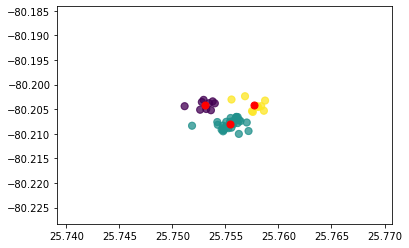

In [54]:
from sklearn.cluster import KMeans

number_of_clusters = 3
good_xys = selected_venues_df.iloc[:,2:4]
#good_xys
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(good_xys['location.lat'], good_xys['location.lng'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)



The clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhood to find the best possible location.

In [55]:
#Narrow the radial perimeter to scan for venues
radius = 0.150 # in kilometer

summary_df = pd.DataFrame(centroids, columns = ['Latitude', 'Longitude']) 
summary_df['Centroid'] = "Centroid "
summary_df['Venues'] = 0
for index, row in summary_df.iterrows():
    summary_df.at[index,'Centroid'] = summary_df.at[index,'Centroid'] + str(index + 1)
    coff_count = 0
        
    #Iterate through the venues dataframe and check if the coffee shop location falls within the increased radius of the neighborhood
    for coff_index, coff_row in venues_df.iterrows():
        a = haversine(float(row['Latitude']), float(row["Longitude"]), coff_row['location.lat'], coff_row['location.lng'])
        if a <= radius:
            coff_count+=1

    summary_df.at[index,'Venues'] = coff_count  
    
avg = round(summary_df["Venues"].mean(),3)

In [64]:
#Reapply the categorization to the refined dataset
summary_df['Category'] = 'gray'
for index, row in summary_df.iterrows():
    if(row['Venues'] > avg):
        summary_df.loc[index, 'Category'] = 'red'
    else:
        if(row['Venues'] == 0):
            summary_df.loc[index, 'Category'] = 'gray'
        else:
            summary_df.loc[index, 'Category'] = 'yellow'

display(summary_df)

,Latitude,Longitude,Centroid,Venues,Category
0,25.753058,-80.204135,Centroid 1,16,yellow
1,25.755396,-80.208083,Centroid 2,48,red
2,25.757696,-80.204231,Centroid 3,12,yellow


In [65]:
mmap = folium.Map(location=[ideal_neighborhood.values[0][3],ideal_neighborhood.values[0][4]], zoom_start=16)
folium.TileLayer('cartodbpositron').add_to(mmap)

#Add marker and perimeter to The Roads neighborhood
folium.Circle([ideal_neighborhood.values[0][3],ideal_neighborhood.values[0][4]], radius=700, color='lightblue', fill=True, fill_opacity=0.4).add_to(mmap)
folium.Marker([ideal_neighborhood.values[0][3],ideal_neighborhood.values[0][4]],popup=ideal_neighborhood.values[0][0]).add_to(mmap)

#Add markers for each centroid
for lat, lon, neigh, category in zip(summary_df['Latitude'],summary_df['Longitude'],summary_df['Centroid'],summary_df['Category']):
    folium.Marker([float(lat), float(lon)], popup=neigh).add_to(mmap)
    folium.Circle([float(lat), float(lon)], radius=150, color=category, fill=True, fill_color=category, fill_opacity=.3).add_to(mmap)

#Add venues / businesses / places of interest to the map
for lat, lng, name, address in zip(selected_venues_df['location.lat'], selected_venues_df['location.lng'], selected_venues_df['name'], selected_venues_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mmap)  
    

#Add coffee shop locations to the map
#The color used to mark coffee shops have been set to red
for lat, lng, name, address in zip(shops_df['location.lat'], shops_df['location.lng'], shops_df['name'], shops_df['location.address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(mmap)    
mmap

In [68]:
#del summary_venues_df
summary_venues_df = selected_venues_df.copy(deep=True)

As we can see Centroid 2 marked in red has the largest cluster and will be the recommended location to establish a new coffee shop

In [ ]:
for idx, row in summary_venues_df.iterrows():
    a = haversine(summary_df.at[1,'Latitude'], summary_df.at[1,'Longitude'], row['location.lat'], row['location.lng'])
    if (a > radius):
        summary_venues_df.drop(idx, inplace=True)

In [70]:
print(len(summary_venues_df))
summary_venues_df.reset_index(drop=True, inplace=True)
summary_venues_df

48


,id,location.address,location.lat,location.lng,location.neighborhood,name
0,5a2ff559364d973caa4c98dc,"2525 SW 3rd Ave, unit Cu2",25.755430,-80.207555,The Roads,Bocas Grill Brickell
1,4f143013e4b04b3f06065308,2498 SW 3rd Ave,25.756415,-80.207406,The Roads,"Dr. Idalia Lastra, D.M.D."
2,4bd9af8a2e6f0f47417a0b08,2525 SW 3rd Ave,25.755683,-80.207425,The Roads,Nordica Condo
3,4c47574b1262ef3b219ccc41,2525 SW 3rd Ave,25.755627,-80.207822,The Roads,Nordica Apartments
4,4ed6eaa877c86e4f2af11cca,NaN,25.755930,-80.206997,The Roads,Kiki's mind
5,4d8f85bed4ec8cfad5d08d89,2525 SW 3rd Ave,25.755074,-80.207552,The Roads,Pool @ Nordica Condominium
6,5419c11c498e11da4a146c34,NaN,25.755758,-80.208011,The Roads,Roads Pediatrics
7,4b808a17f964a5202e7b30e3,NaN,25.756279,-80.207183,The Roads,Saint Sophia
8,4da60bbfcda1b0253fe9b5ba,2525 SW 3rd Ave,25.755590,-80.207900,The Roads,"Dr Cordero, Perez-Silva Pediatrics"
9,4c93d15903413704822b6cef,NaN,25.754230,-80.207594,The Roads,Beth David Congregation


This concludes our analysis. 

We can see that choosing the location at Centroid 2 will service approximately 48 businesses with no other competing coffee shops in close proximity.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to aid stakeholders in narrowing down the search for optimal location for a new coffee shop in the vicinity of Downtown Miami. We identified prospective neighborhoods, and then identified existing coffee shop distributions and supporting businesses using Foursquare data.
<br/><br/>
Clustering analysis of those locations was then evaluated to determine the most viable option for a new coffee shop. The recommended solution satisfied low competition from other coffee shops, with supporting business establishments around whilst also being close to Downtown Miami.